In [1]:
import keras
from keras import layers
from keras.datasets import cifar10
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob
from sklearn.decomposition import PCA

Download the dataset from http://chaladze.com/l5/

In [2]:
train = glob.glob("./Linnaeus 5 128X128/train/dog/*.jpg")[:200] # 1200
train = train + glob.glob("./Linnaeus 5 128X128/train/flower/*.jpg")[:200] # 1200
train = train + glob.glob("./Linnaeus 5 128X128/train/bird/*.jpg")[:200] # 1200

test = glob.glob("./Linnaeus 5 128X128/test/dog/*.jpg")[:200] # 1200
test = test + glob.glob("./Linnaeus 5 128X128/test/flower/*.jpg")[:200] # 1200
test = test + glob.glob("./Linnaeus 5 128X128/test/bird/*.jpg")[:200] # 1200

# Shuffle Data
import random

random.shuffle(train)
random.shuffle(test)

In [5]:
train_tensor = []
for image in train:
  img = cv2.imread(image)
  train_tensor.append(img)
train = np.float32(train_tensor)/255.0

test_tensor = []
for image in test:
  img = cv2.imread(image)
  test_tensor.append(img)
test = np.float32(test_tensor)/255.0
  

In [28]:
# Add noise to inpyt data
noise = np.random.normal(0, 0.1, size=(len(train), 128, 128, 3))

noisy_train = np.float32(train + noise)
noisy_test = np.float32(test + np.random.normal(0, 0.1, size=(len(test), 128, 128, 3)))

In [7]:
noisy_train.shape

(600, 128, 128, 3)

In [8]:
dog_img = cv2.imread("./dog_img.jpg")/255.0
dog_img = cv2.resize(dog_img, (128, 128))
noisy_dog_img = dog_img + np.random.normal(0, 0.1, size=(dog_img.shape[0], dog_img.shape[1], 3))
dog_img = np.float32(dog_img)
noisy_dog_img = np.float32(noisy_dog_img)

In [22]:
def plotImg(img):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGBA))
    plt.show()

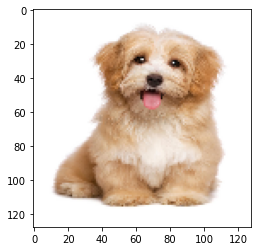

In [10]:
plotImg(dog_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


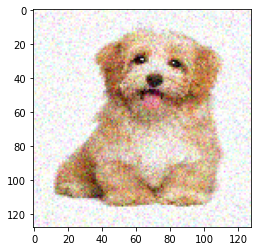

In [27]:

plotImg(noisy_dog_img)

In [18]:
from keras.layers.convolutional.conv1d import activations
def create_autoencoder(vec_size):

  input = keras.Input(shape=(128, 128, 3))

  # 128x128x3
  x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input) # 128x128x16
  x = layers.MaxPooling2D((2, 2), padding='same')(x) # 64x64x16
  x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x) # 64x64x32
  x = layers.MaxPooling2D((2, 2), padding='same')(x) # 32x32x32
  x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x) # 32x32x64
  x = layers.MaxPooling2D((2, 2), padding='same')(x) # 16x16x32
  x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x) # 16x16x1 = 256
  # pool = 256/vec_size
  # x = layers.MaxPooling2D((pool, pool), padding='same')(x)
  x = layers.Flatten()(x)
  x = layers.Dense(vec_size, activation = activations.relu)(x)

  encoded = x

  x = layers.Dense(32768, activation = activations.relu)(encoded)

  x = layers.Reshape((16, 16, 128))(x)
  # at this point the representation is (vec_size, 1)

  # stride * (in_size-1) + kernel_size - 2*padding

  x = layers.Conv2DTranspose(32, (3, 3), strides=(2,2), activation='relu', padding='same')(x)
  x = layers.Conv2DTranspose(16, (3, 3), strides=(2,2), activation='relu', padding='same')(x)
  x = layers.Conv2DTranspose(8, (3, 3), strides=(2,2), activation='relu', padding='same')(x)
  decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

  autoencoder = keras.Model(input, decoded)
  autoencoder.compile(optimizer='adam', loss='mean_squared_error')

  return autoencoder, encoded, decoded


In [19]:
autoencoder1, enc1, dec1 = create_autoencoder(8)
autoencoder1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 16)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 64)        1849

In [20]:
autoencoder1.fit(noisy_train, train,
                epochs=100,
                batch_size=28,
                shuffle=True,
                validation_data=(noisy_test, test))

decoded_imgs = autoencoder1.predict(noisy_test)

Epoch 1/100
22/22 [==============================] - 3s 77ms/step - loss: 0.0736 - val_loss: 0.0725
Epoch 2/100
22/22 [==============================] - 1s 48ms/step - loss: 0.0708 - val_loss: 0.0704
Epoch 3/100
22/22 [==============================] - 1s 48ms/step - loss: 0.0664 - val_loss: 0.0641
Epoch 4/100
22/22 [==============================] - 1s 46ms/step - loss: 0.0624 - val_loss: 0.0599
Epoch 5/100
22/22 [==============================] - 1s 47ms/step - loss: 0.0594 - val_loss: 0.0578
Epoch 6/100
22/22 [==============================] - 1s 45ms/step - loss: 0.0569 - val_loss: 0.0557
Epoch 7/100
22/22 [==============================] - 1s 47ms/step - loss: 0.0550 - val_loss: 0.0530
Epoch 8/100
22/22 [==============================] - 1s 48ms/step - loss: 0.0518 - val_loss: 0.0506
Epoch 9/100
22/22 [==============================] - 1s 48ms/step - loss: 0.0500 - val_loss: 0.0481
Epoch 10/100
22/22 [==============================] - 1s 51ms/step - loss: 0.0480 - val_loss: 0.0475

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


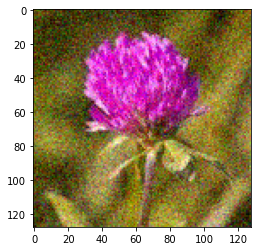

In [36]:
plotImg(noisy_test[33])

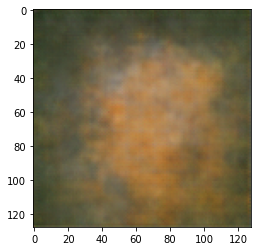

In [35]:
plotImg(decoded_imgs[33])

In [ ]:
pca8 = PCA(8)
pca.fit_transform(noisy_train.ravel())

In [38]:
autoencoder16, enc16, dec16 = create_autoencoder(16)
autoencoder16.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_10 (Conv2D)          (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 64, 64, 16)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 32, 32, 64)        1849

In [39]:
autoencoder16.fit(noisy_train, train,
                epochs=150,
                batch_size=28,
                shuffle=True,
                validation_data=(noisy_test, test))

decoded_imgs16 = autoencoder16.predict(noisy_test)

Epoch 1/150
22/22 [==============================] - 2s 53ms/step - loss: 0.0736 - val_loss: 0.0739
Epoch 2/150
22/22 [==============================] - 1s 33ms/step - loss: 0.0712 - val_loss: 0.0714
Epoch 3/150
22/22 [==============================] - 1s 34ms/step - loss: 0.0695 - val_loss: 0.0679
Epoch 4/150
22/22 [==============================] - 1s 34ms/step - loss: 0.0639 - val_loss: 0.0598
Epoch 5/150
22/22 [==============================] - 1s 35ms/step - loss: 0.0552 - val_loss: 0.0499
Epoch 6/150
22/22 [==============================] - 1s 41ms/step - loss: 0.0490 - val_loss: 0.0471
Epoch 7/150
22/22 [==============================] - 1s 39ms/step - loss: 0.0464 - val_loss: 0.0460
Epoch 8/150
22/22 [==============================] - 1s 38ms/step - loss: 0.0447 - val_loss: 0.0438
Epoch 9/150
22/22 [==============================] - 1s 39ms/step - loss: 0.0438 - val_loss: 0.0437
Epoch 10/150
22/22 [==============================] - 1s 42ms/step - loss: 0.0438 - val_loss: 0.0435

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


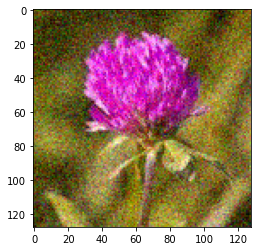

In [40]:
plotImg(noisy_test[33])

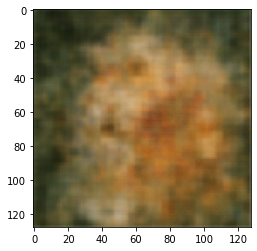

In [41]:
plotImg(decoded_imgs16[33])

In [138]:
autoencoder32, enc32, dec32 = create_autoencoder(32)
autoencoder32.summary()

In [ ]:
autoencoder64, enc64, dec64 = create_autoencoder(64)
autoencoder64.summary()

In [ ]:
autoencoder64, enc64, dec64 = create_autoencoder(64)
autoencoder64.summary()